In [2]:
from langchain_openai.chat_models import ChatOpenAI
from dotenv import load_dotenv
import os

load_dotenv()
key = os.getenv('openai_key')

gpt4 = "gpt-4o-mini"
gpt3 = "gpt-3.5-turbo"
llm = ChatOpenAI(api_key=key, model=gpt3, temperature=0)

In [3]:
from typing import Annotated, List, Tuple, Union
from langchain.tools import BaseTool, StructuredTool, Tool

from langchain_experimental.tools import PythonREPLTool
from langchain_core.tools import tool
from langchain_core.utils.function_calling import convert_to_openai_function
import random

# This executes code locally, which can be unsafe
python_repl = PythonREPLTool(return_direct=False
                                  )
repl_tool = Tool(
    name="python_repl",
    description="A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.",
    func=python_repl.run,
)
python_repl_tool = convert_to_openai_function(repl_tool)

In [4]:
print(repl_tool.description)

A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.


In [14]:
# my custom tools
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List

class HistInput(BaseModel):
    input_number:List[int] = Field(description='Should be a list of integer numbers')
    bins:int = Field(description='interger number of the number of bins')

class LowerCaseInput(BaseModel):
    text:str = Field(description="A text that will be lower case")

@tool("hist", return_direct=False, args_schema=HistInput)
def hist(input_numbers:List[int], bins:int=10) -> None:
  """Plot the histogram of a given array and the number. For instance: 1,2,3"""
  from matplotlib import pyplot as plt
  bins = int(bins)
  plt.hist(x=input_numbers, bins=bins)
  plt.show()
  return input_numbers

@tool("lower_case", return_direct=False, args_schema= LowerCaseInput)
def to_lower_case(input:str) -> str:
  """Returns the input as all lower case."""
  return input.lower()

@tool("random_number", return_direct=False)
def random_number_maker() -> str:
    """Returns a random number between 0-100. input the word 'random'"""
    return random.randint(0, 100)

tools = [to_lower_case, random_number_maker, hist]

In [15]:
print(hist.args)

{'input_number': {'title': 'Input Number', 'description': 'Should be a list of integer numbers', 'type': 'array', 'items': {'type': 'integer'}}, 'bins': {'title': 'Bins', 'description': 'interger number of the number of bins', 'type': 'integer'}}


In [16]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts.chat import ChatPromptTemplate, MessagesPlaceholder


def create_agent(llm: ChatOpenAI, tools:list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools
                            #  ,verbose=True,
                             )
    return executor

In [8]:
teste = 'vamos la {content}'
mfs = teste.format(content = 'motherfucker')
print(teste)
print(mfs)

vamos la {content}
vamos la motherfucker


In [9]:
# agent node
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

In [10]:
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

members = ["Lotto_Manager", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members
# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

In [26]:
from langchain_core.tools import tool
from typing import List, Type
import random
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import BaseTool

## Schemas:

class HistInput(BaseModel):
    input_number:List[int] = Field(description='Should be a list of integer numbers')
    bins:int = Field(description='interger number of the number of bins')

class LowerCaseInput(BaseModel):
    text:str = Field(description="A text that will be lower case")

## Tools:

class HistTool(BaseTool):
    name = 'hist_tool'
    description="""Plot the histogram of a given array and the number. For instance: 1,2,3"""
    args_schema: Type[BaseModel] = HistInput

    def _run(self,
             input_numbers:List[int],
             bins: int
             ) -> List[int]:
        from matplotlib import pyplot as plt
        plt.hist(x=input_numbers, bins=bins)
        plt.show()
        return input_numbers

class RandomTool(BaseTool):
    name='random_tool'
    description="""Returns a random number between 0-100. input the word 'random'"""

    def _run(self) -> int:
        return random.randint(0, 100)

class LowerCaseTool(BaseTool):
    name = 'lower_case_tool'
    description= 'Returns the input as all lower case.'
    args_schema: Type[BaseModel] = LowerCaseInput
    def _run(self,
             text:str
             ) -> str:
        return text.lower()

In [27]:
import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
import functools

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


lotto_agent = create_agent(llm,tools =[RandomTool()], system_prompt= "You are a senior lotto manager. you run the lotto and get random numbers.")
lotto_node = functools.partial(agent_node, agent=lotto_agent, name="Lotto_Manager")

hist_agent = create_agent(llm, tools=[HistTool()], system_prompt= "You may generate as list and a number of bins for the tool to plot a histogram.")
hist_node = functools.partial(agent_node, agent=hist_agent, name="Coder")

# code_agent = create_agent(llm, tools=[repl_tool],system_prompt= "You may generate safe python code to analyze data and generate charts using matplotlib.")
# code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
workflow.add_node("Lotto_Manager", lotto_node)
workflow.add_node("Coder", hist_node)
workflow.add_node("supervisor", supervisor_chain)

In [28]:
import json
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor") # add one edge for each of the agents
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
print(json.dumps(conditional_map, indent=4, default= str))
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.set_entry_point("supervisor")

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph = workflow.compile(checkpointer=memory)

{
    "Lotto_Manager": "Lotto_Manager",
    "Coder": "Coder",
    "FINISH": "__end__"
}


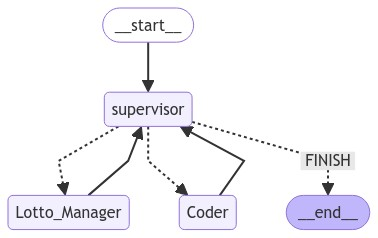

In [23]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [29]:
thread1 = {"configurable": {"thread_id": "2"}}
final_response = graph.invoke(input=
    {
        "messages": [
            HumanMessage(content="""Get 5 random lotto numbers and plot them on a histogram in 
                         3 bins
                          and tell me what the 
                         5 numbers are at the end""")
        ]
    },
    config= thread1
)

In [30]:
final_response

import json
print(
    json.dumps(graph.get_state(thread1), 
           indent=4, 
           default=str
           )
)

[
    {
        "messages": [
            "content='Get 5 random lotto numbers and plot them on a histogram in \\n                         3 bins\\n                          and tell me what the \\n                         5 numbers are at the end'",
            "content=\"The 5 random lotto numbers are: 9, 40, 71, 24, 45.\\n\\nNow, let's plot these numbers on a histogram with 3 bins.\\nHere is the histogram with the 5 random lotto numbers (9, 40, 71, 24, 45) plotted in 3 bins:\\n\\n- Bin 1: 9, 24\\n- Bin 2: 40, 45\\n- Bin 3: 71\" name='Lotto_Manager'"
        ],
        "next": "FINISH"
    },
    [],
    {
        "configurable": {
            "thread_id": "2",
            "checkpoint_ns": "",
            "checkpoint_id": "1ef64b2c-4aca-6eea-8003-c10a49d564c9"
        }
    },
    {
        "source": "loop",
        "writes": {
            "supervisor": {
                "next": "FINISH"
            }
        },
        "step": 3
    },
    "2024-08-27T20:27:23.838231+00:00",
    {
 

In [91]:
msg =  [HumanMessage(content='''Get 10 random lotto numbers
                    and plot them on a histogram in 5 bins
                    and tell me what the 10 numbers are at the end''')]

thread2 = {"configurable": {"thread_id": "2"}}

for event in graph.stream({"messages": msg}, thread2):
    for v in event.values():
        print(v)

{'next': 'Lotto_Manager'}
{'messages': [HumanMessage(content="The 10 random lotto numbers are: 42, 95, 81, 0, 17, 6, 33, 54, 15, 81.\n\nNow, let's plot these numbers on a histogram with 5 bins.\nHere is the histogram plot of the 10 random lotto numbers in 5 bins:\n\n```\n0-20: ██\n20-40: █\n40-60: ██\n60-80: \n80-100: ██\n``` \n\nThe numbers are: 42, 95, 81, 0, 17, 6, 33, 54, 15, 81.", name='Lotto_Manager')]}
{'next': 'FINISH'}


In [95]:
import json
print(
    json.dumps(graph.get_state(thread2), 
           indent=4, 
           default=str
           )
)

[
    {
        "messages": [
            "content='Get 10 random lotto numbers\\n                    and plot them on a histogram in 5 bins\\n                    and tell me what the 10 numbers are at the end'",
            "content=\"The 10 random lotto numbers are: 42, 95, 81, 0, 17, 6, 33, 54, 15, 81.\\n\\nNow, let's plot these numbers on a histogram with 5 bins.\\nHere is the histogram plot of the 10 random lotto numbers in 5 bins:\\n\\n```\\n0-20: \u2588\u2588\\n20-40: \u2588\\n40-60: \u2588\u2588\\n60-80: \\n80-100: \u2588\u2588\\n``` \\n\\nThe numbers are: 42, 95, 81, 0, 17, 6, 33, 54, 15, 81.\" name='Lotto_Manager'"
        ],
        "next": "FINISH"
    },
    [],
    {
        "configurable": {
            "thread_id": "2",
            "checkpoint_ns": "",
            "checkpoint_id": "1ef64086-f233-6fb3-8003-0022fd7ffa99"
        }
    },
    {
        "source": "loop",
        "writes": {
            "supervisor": {
                "next": "FINISH"
            }
        }

In [97]:
for state in graph.get_state_history(thread2):
    print(state)
    print(json.dumps(state.values, indent=4, default= str))

StateSnapshot(values={'messages': [HumanMessage(content='Get 10 random lotto numbers\n                    and plot them on a histogram in 5 bins\n                    and tell me what the 10 numbers are at the end'), HumanMessage(content="The 10 random lotto numbers are: 42, 95, 81, 0, 17, 6, 33, 54, 15, 81.\n\nNow, let's plot these numbers on a histogram with 5 bins.\nHere is the histogram plot of the 10 random lotto numbers in 5 bins:\n\n```\n0-20: ██\n20-40: █\n40-60: ██\n60-80: \n80-100: ██\n``` \n\nThe numbers are: 42, 95, 81, 0, 17, 6, 33, 54, 15, 81.", name='Lotto_Manager')], 'next': 'FINISH'}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1ef64086-f233-6fb3-8003-0022fd7ffa99'}}, metadata={'source': 'loop', 'writes': {'supervisor': {'next': 'FINISH'}}, 'step': 3}, created_at='2024-08-27T00:08:05.887173+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1ef64086-eae3-662c-8002-d84e5396ac31'}